In [1]:
import xarray as xr
import fsspec
import os
import matplotlib.pyplot as plt
import numpy as np
import vcm
from vcm.catalog import catalog 
import dask.diagnostics
import math
import cftime
import time
import fv3viz
import joblib

import sys
import ocsvm

from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from vcm.cubedsphere import GridMetadataScream

In [2]:
def time_sample(dataset, num_times):
    return dataset.isel(time=np.random.choice(range(dataset.time.size), size=num_times, replace=False)).sortby("time")

def get_sampled_array(dataset, field, num_times):
    subset = time_sample(dataset, num_times)
    stacked = subset \
        .stack(sample=["time", "ncol"]) \
        .transpose("sample", ...)
    return stacked[field]


The data used here can be post processed using convert-native-scream-to-zarr. Alternatively, you can also use native scream output and open the data using `xr.open_mfdataset`.

In [3]:
gamma = 1./128.
nu = 0.1
dataset_name = "20231208-ne30-nudged-run"
prog_dataset_name = "prog-n2f-2010-ml"
# training data is from the nudged run
training_data = xr.open_zarr("/p/lustre1/wu62/EAMxx/20231208.F2010-SCREAMv1.ne30pg2_ne30pg2.ruby/tests/840x1_1x1_ndays_nudged/run/2010_zarr/state_after_timestep.zarr")
# prognostic data is used to evaluate the trained model
prognostic_data = xr.open_zarr("/usr/workspace/wu62/scream-docs/nudge-to-fine-scream-workflow/workflows/prepare-native-scream-output/convert-native-scream-to-zarr/2010.zarr/state_after_timestep.zarr")

In [4]:
start_time = prognostic_data.time.min().item()
end_time = prognostic_data.time.max().item()
training_data = training_data.sel(time=slice(start_time, end_time))

In [5]:
training_temp = get_sampled_array(training_data, "T_mid", 10)
prognostic_temp = get_sampled_array(prognostic_data, "T_mid", 10)

In [6]:
trials = []
clfs = {}
prognostic_scores = {}
cutoffs = {}
paths = {}

/usr/workspace/wu62/miniconda3/envs/fv3net/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time to train model: 533.4592161178589s
Time to evaluate model on training data: 385.95492458343506s


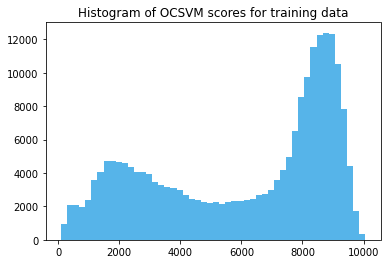

Time elasped: 427.5804581642151s


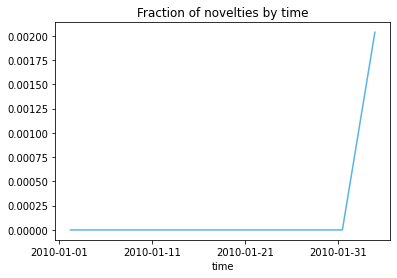

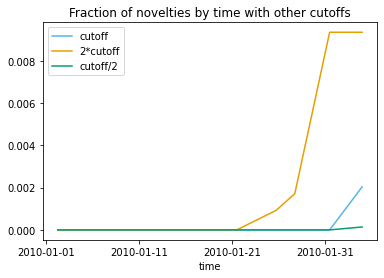

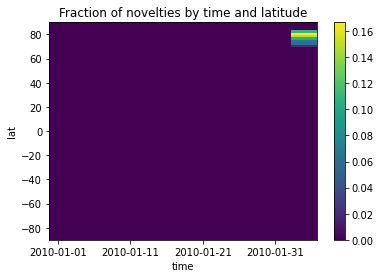

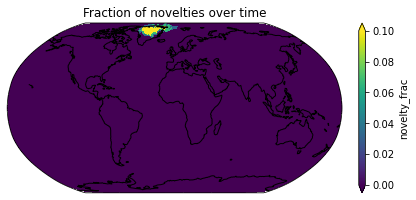

Total fraction of novelties: 0.0002037037037037037


In [7]:
clf, prog_scores, cutoff, trial, path = \
ocsvm.train_and_eval_ocsvm(
    1/79, # gamma
    0.1, # nu
    dataset_name,
    training_temp,
    prog_dataset_name,
    prognostic_temp,
    save_model=False)
trials.append(trial)
(clfs[trial], prognostic_scores[trial], cutoffs[trial], paths[trial]) = (clf, prog_scores, cutoff, path)

/usr/workspace/wu62/miniconda3/envs/fv3net/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time to train model: 535.0925636291504s
Time to evaluate model on training data: 379.4924068450928s


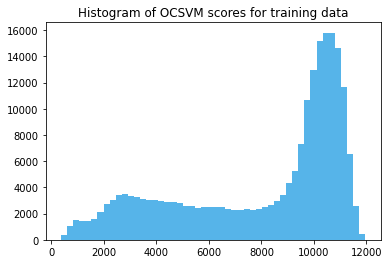

Time elasped: 454.3448431491852s


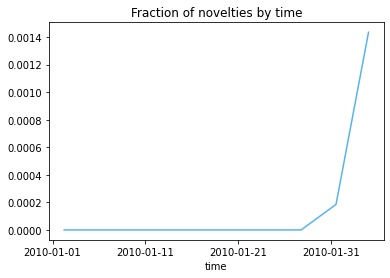

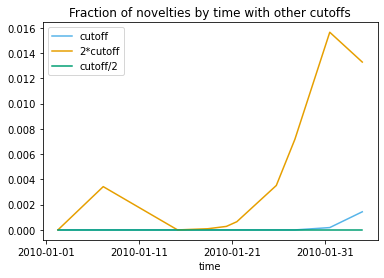

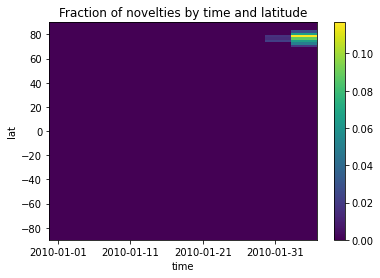

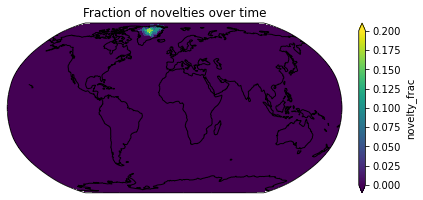

Total fraction of novelties: 0.00016203703703703703


In [8]:
clf, prog_scores, cutoff, trial, path = \
ocsvm.train_and_eval_ocsvm(
    1/128,
    0.1,
    dataset_name,
    training_temp,
    prog_dataset_name,
    prognostic_temp,
    save_model=False)
trials.append(trial)
(clfs[trial], prognostic_scores[trial], cutoffs[trial], paths[trial]) = (clf, prog_scores, cutoff, path)

/usr/workspace/wu62/miniconda3/envs/fv3net/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time to train model: 533.1644175052643s
Time to evaluate model on training data: 470.5637276172638s


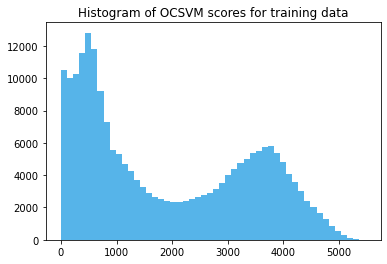

Time elasped: 435.4094521999359s


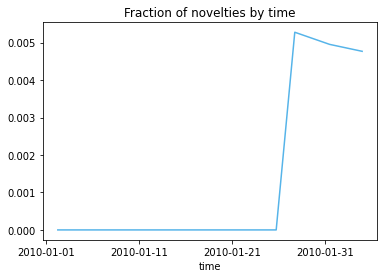

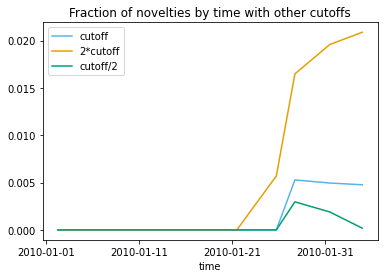

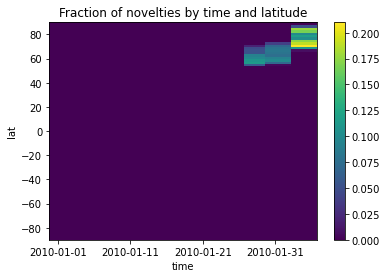

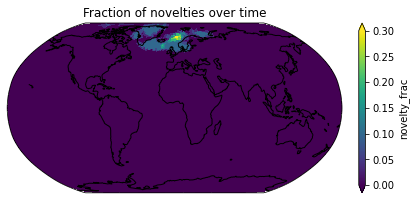

Total fraction of novelties: 0.0015


In [9]:
clf, prog_scores, cutoff, trial, path = \
ocsvm.train_and_eval_ocsvm(
    4/79,
    0.1,
    dataset_name,
    training_temp,
    prog_dataset_name,
    prognostic_temp,
    save_model=False)
trials.append(trial)
(clfs[trial], prognostic_scores[trial], cutoffs[trial], paths[trial]) = (clf, prog_scores, cutoff, path)

/usr/workspace/wu62/miniconda3/envs/fv3net/lib/python3.8/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Time to train model: 75.77332353591919s
Successfully saved model to path ocsvm_20231208-ne30-nudged-run_216000_0.012658227848101266_0.01.pkl
Time to evaluate model on training data: 41.7784218788147s


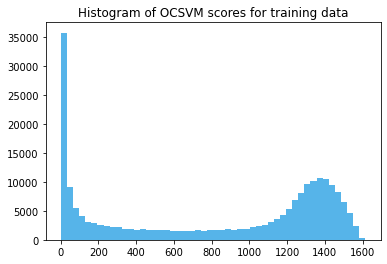

Time elasped: 41.18525791168213s


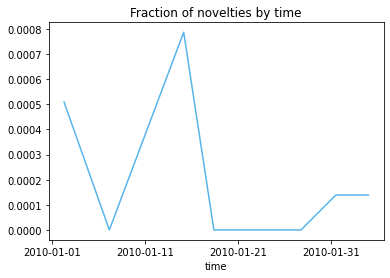

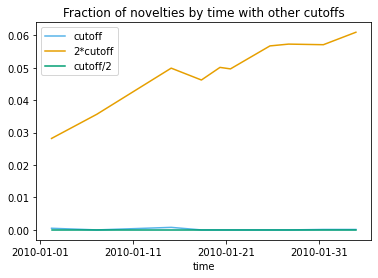

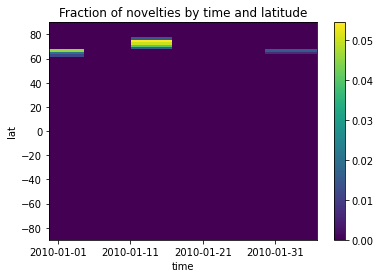

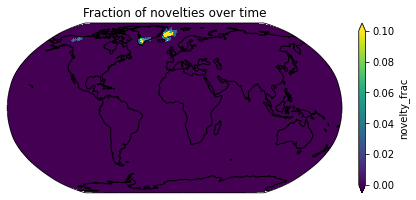

Total fraction of novelties: 0.0001574074074074074


In [13]:
clf, prog_scores, cutoff, trial, path = \
ocsvm.train_and_eval_ocsvm(
    1/79,
    1e-2,
    dataset_name,
    training_temp,
    prog_dataset_name,
    prognostic_temp,
    save_model=True)
trials.append(trial)
(clfs[trial], prognostic_scores[trial], cutoffs[trial], paths[trial]) = (clf, prog_scores, cutoff, path)